## Projet Machine learning : emission de CO2 des véhicules commercial en France 


- python (3.12.7) anaconda



### chargement du jeu de donnée du format csv à xls pour une meilleur lisibilité


In [20]:
import pandas as pd

file = "CO2_2015.csv"
# Try common encodings
encodings = ["utf-8", "latin1", "iso-8859-1", "cp1252"]

for enc in encodings:
    try:
        df = pd.read_csv(file, sep=';', decimal=',', encoding=enc)
        print(f"Success with encoding: {enc}")
        break
    except UnicodeDecodeError:
        continue

# Save as .xls
df.to_excel("CO2_2015VF.xlsx", index=False, engine="openpyxl")

Success with encoding: latin1


## premiere affichage descriptif des donnée afin d'avoir un apperçu 

In [2]:
import pandas as pd
df = pd.read_csv("CO2.csv", sep=";", encoding="latin1")
print("\nLe jeu de donnée à été charger avec succes !\n")

# Aperçu des données
print('\n',df.head())
print(' ')

# Informations sur les colonnes
print(df.info())

# Statistiques descriptives
print('\n',df.describe())

# Dimensions du dataset
print('\n',f"Dimensions : {df.shape}")
print('')

print('\n',df.describe(include='object'))


Le jeu de donnée à été charger avec succes !


       lib_mrq lib_mod_doss lib_mod                 dscom             cnit  \
0  ALFA-ROMEO          159     159  159 1750 Tbi (200ch)  M10ALFVP000G340   
1  ALFA-ROMEO          159     159  159 1750 Tbi (200ch)  M10ALFVP000H341   
2  ALFA-ROMEO          159     159  159 2.0 JTDm (136ch)  M10ALFVP000E302   
3  ALFA-ROMEO          159     159  159 2.0 JTDm (136ch)  M10ALFVP000F303   
4  ALFA-ROMEO          159     159  159 2.0 JTDm (170ch)  M10ALFVP000G304   

           tvv cod_cbr hybride  puiss_admin_98 puiss_max  ... masse_ordma_min  \
0  939AXN1B52C      ES     non              12       147  ...            1505   
1  939BXN1B53C      ES     non              12       147  ...            1555   
2   939AXR1B64      GO     non               7       100  ...            1565   
3  939AXR1B64B      GO     non               7       100  ...            1565   
4   939AXS1B66      GO     non               9       125  ...            1565   

 

In [142]:
print(df.isna().sum())

lib_mrq                  0
lib_mod_doss             0
lib_mod                  0
dscom                    0
cnit                     0
tvv                      0
cod_cbr                  0
hybride                  0
puiss_admin_98           0
puiss_max                0
typ_boite_nb_rapp        0
conso_urb               43
conso_exurb             43
conso_mixte             34
co2                     34
co_typ_1               158
hc                   45271
nox                    158
hcnox                 9888
ptcl                  2678
masse_ordma_min          0
masse_ordma_max          0
champ_v9                61
date_maj             51797
Carrosserie              0
gamme                    0
Unnamed: 26          55044
Unnamed: 27          55044
Unnamed: 28          55044
Unnamed: 29          55044
dtype: int64


## analyse des données manquante et partie netoyage
- on va enlevé les colonnes vide ou avec trop d'objet nul  
   > ne pouvant être enpûter sans rajouter de biais c'est colonne ne ferais que pertubé notre modéles
- on va aussi enlevé les colonnes qui n'apporterait pas de connaissance réel a notre model
- on va finalement enlevé les colonnes qui contient déjà la reponse afin d'éviter qui le modèles apprennent des connaissance notre reutilisable

In [3]:
# analyse des données manquant puis netoyage echellonée de c'est donnée
print(" ")
print(len(df))

# suppression de column vide dans le jeux de données 
df.drop(['Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'date_maj', 'hc'], axis=1, inplace=True)

# enlévé les variable qui ne serviront a rien dans la prediction ou qui risque d'engendre du bruit.
df.drop(['cnit', 'tvv', 'puiss_admin_98', 'co_typ_1', 'dscom', 'hcnox', 'nox'], axis=1, inplace=True)

# suppression des colomn de consomation car il donne déjà des information sur les emission de C02 
df.drop(['conso_urb', 'conso_exurb', 'conso_mixte', 'ptcl'], axis=1, inplace=True)
# cars CO2 = conso_mixte * constante, donc le modeles risque d'apprendre le mauvais calcule même si le resultat sera bon 

# car le nom du vehicule n'affecte pas les emission de CO2 donc c'est donner risque de nous ménee a un état de sur-apprentissage 
df.drop(['lib_mod', 'lib_mod_doss'], axis=1, inplace=True)

print(df.isna().sum())

 
55044
lib_mrq               0
cod_cbr               0
hybride               0
puiss_max             0
typ_boite_nb_rapp     0
co2                  34
masse_ordma_min       0
masse_ordma_max       0
champ_v9             61
Carrosserie           0
gamme                 0
dtype: int64


In [98]:
print(df.dtypes)

lib_mrq               object
cod_cbr               object
hybride               object
puiss_max             object
typ_boite_nb_rapp     object
conso_mixte           object
co2                  float64
co_typ_1              object
nox                   object
ptcl                  object
masse_ordma_min        int64
masse_ordma_max        int64
champ_v9              object
Carrosserie           object
gamme                 object
dtype: object


### netoyage des differente variable retenu

- enputtage des variable avec valeur manquantes
- séparation du champ_v9 afin de garde la norme euro qui pourrait être utile
- creation d'un nouveau champ norme euro, et suppression du champ_v9
- creation d'un champ masse moyenne afin de remplace les champ mass_ordma_min/max quii contient des valeur tres proches les une des autres
- conversion des types de chaque variable afin de les faire correspondre à ceux qu'il devrait representer

In [4]:
# 1. Nettoyage CO2
df['co2'] = pd.to_numeric(df['co2'], errors='coerce')
df['co2'] = df['co2'].fillna(df['co2'].mean())

# 2. Extraction de caractéristiques (Feature Engineering)

df['euro_num'] = df['champ_v9'].str.extract(r'(\d+)$').astype(float)

# 3. Remplissage des nouveaux NaN

df['euro_num'] = df['euro_num'].fillna(df['euro_num'].median())

df.drop('champ_v9', axis=1, inplace=True)



### separation des type de boite et du nombre de vitesse 
- creation de deux nouvelle colonnes qui represente le nombre de boite et une qui represnte le types de boite utilise dans le vehicules


In [5]:
# 1. On sépare la colonne en utilisant l'espace comme délimiteur

split_boite = df['typ_boite_nb_rapp'].str.split(' ', expand=True)

# 2. On assigne les résultats aux nouvelles colonnes
df['type_boite'] = split_boite[0]

# 3. On convertit le nombre de rapports en numérique
# errors='coerce' transformera les éventuels textes bizarres en NaN
df['nb_rapports'] = pd.to_numeric(split_boite[1], errors='coerce')

# 4. Suppression de l'ancienne colonne pour éviter les doublons
df.drop('typ_boite_nb_rapp', axis=1, inplace=True)

# Vérification
print(df[['type_boite', 'nb_rapports']].head())


  type_boite  nb_rapports
0          M          6.0
1          M          6.0
2          M          6.0
3          M          6.0
4          M          6.0


In [6]:
# emputation de nb_rapports
df['nb_rapports'] = df['nb_rapports'].fillna(df['nb_rapports'].mode()[0])
df['nb_rapports'] = df['nb_rapports'].astype('int64')

In [7]:
# errors='coerce' transforme ce qui n'est pas un chiffre en NaN
df['puiss_max'] = pd.to_numeric(df['puiss_max'], errors='coerce')
df.fillna(df['puiss_max'].mode()[0], axis=1, inplace=True)

In [8]:
df['masse_moyenne'] = (df['masse_ordma_max'] + df['masse_ordma_min'])/2
df.drop(['masse_ordma_max', 'masse_ordma_min'], axis=1, inplace=True)

In [156]:
print(df.dtypes)

lib_mrq          object
cod_cbr          object
hybride          object
puiss_max        object
co2              object
Carrosserie      object
gamme            object
euro_num         object
type_boite       object
nb_rapports      object
masse_moyenne    object
dtype: object


In [9]:
import pandas as pd

# Liste des colonnes à convertir
cols_to_fix = ['puiss_max', 'co2', 'euro_num', 'nb_rapports', 'masse_moyenne']

# Conversion en numérique
# errors='coerce' transforme les valeurs non-numériques (ex: du texte) en NaN pour éviter de bloquer le code
for col in cols_to_fix:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Optionnel : Remplacer les nouveaux NaNs créés par la moyenne ou le mode si besoin
# Car on ne peut pas convertir en int64 s'il reste des NaNs
df[cols_to_fix] = df[cols_to_fix].fillna(0) # Exemple avec 0, ou utilisez vos méthodes précédentes

# Conversion finale en types spécifiques
df['nb_rapports'] = df['nb_rapports'].astype('int64')
df['euro_num'] = df['euro_num'].astype('int64')
# Les autres (puiss_max, co2, masse) sont souvent mieux en float
print(df.dtypes)


lib_mrq           object
cod_cbr           object
hybride           object
puiss_max        float64
co2              float64
Carrosserie       object
gamme             object
euro_num           int64
type_boite        object
nb_rapports        int64
masse_moyenne    float64
dtype: object


### analyse graphique EDA

Statistiques des variables clés :
                co2     puiss_max  masse_moyenne   nb_rapports      euro_num
count  55044.000000  55044.000000   55044.000000  55044.000000  55044.000000
mean     201.707035    118.852173    2221.563177      5.840800      5.099684
std       33.965783     44.781925     341.108551      0.797571      8.604420
min       13.000000     10.000000     825.000000      0.000000      1.000000
25%      193.000000    100.000000    2063.500000      5.000000      5.000000
50%      205.000000    120.000000    2270.500000      6.000000      5.000000
75%      216.000000    120.000000    2457.500000      6.000000      5.000000
max      572.000000    585.000000    2840.000000      9.000000   2013.000000
--- Lancement de l'Analyse Exploratoire (EDA) ---


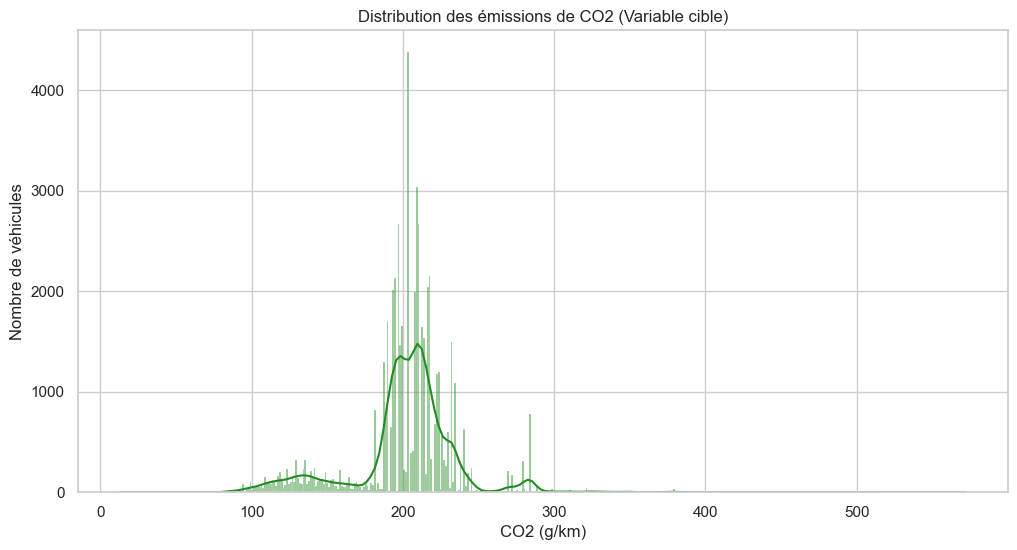

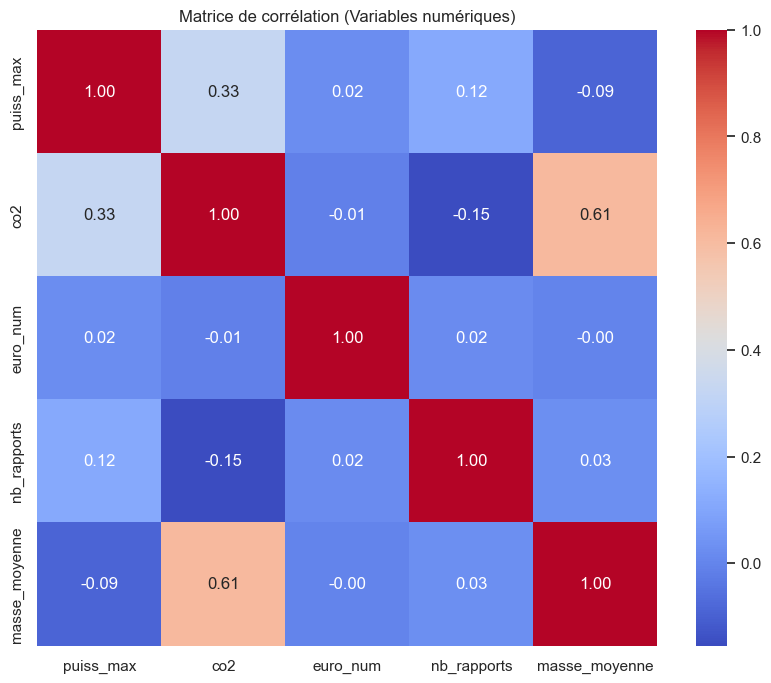

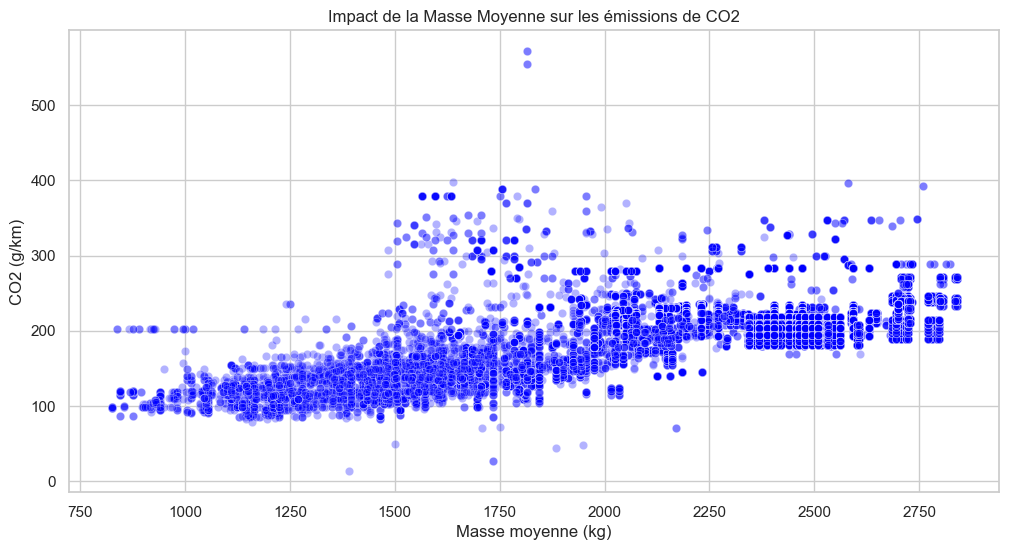

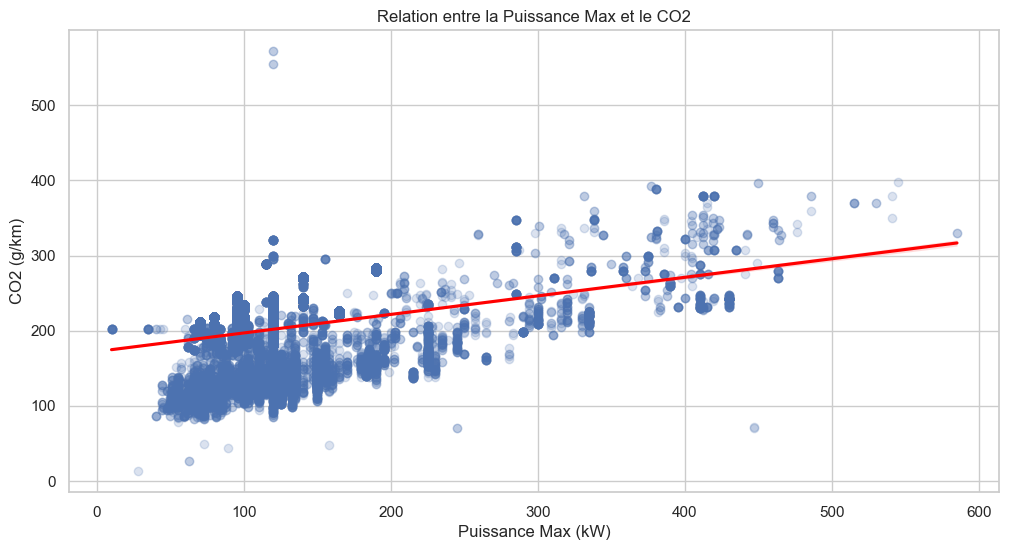

C:\Users\wambo\AppData\Local\Temp\ipykernel_24960\3652314696.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cod_cbr', y='co2', palette='Set2')


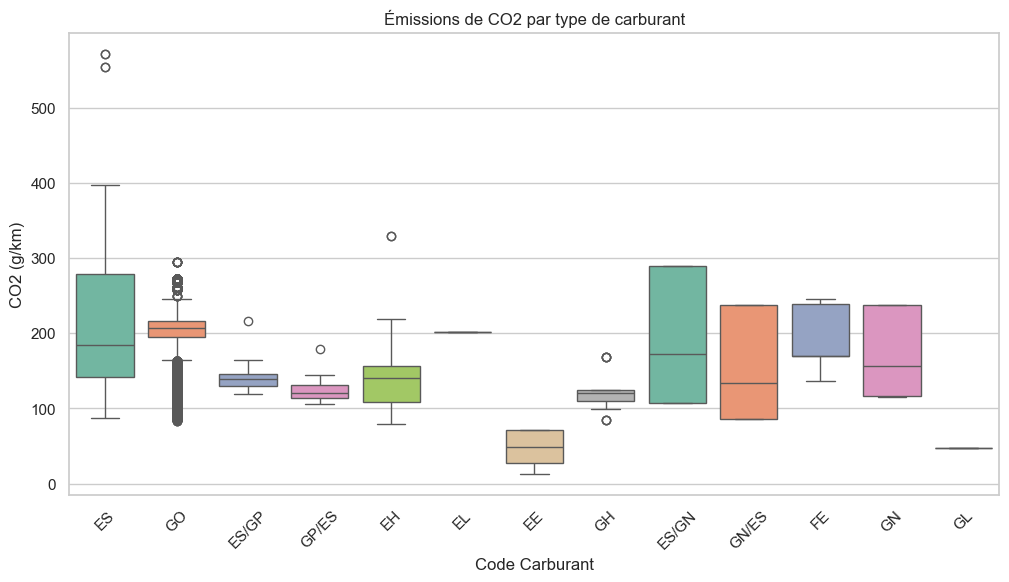

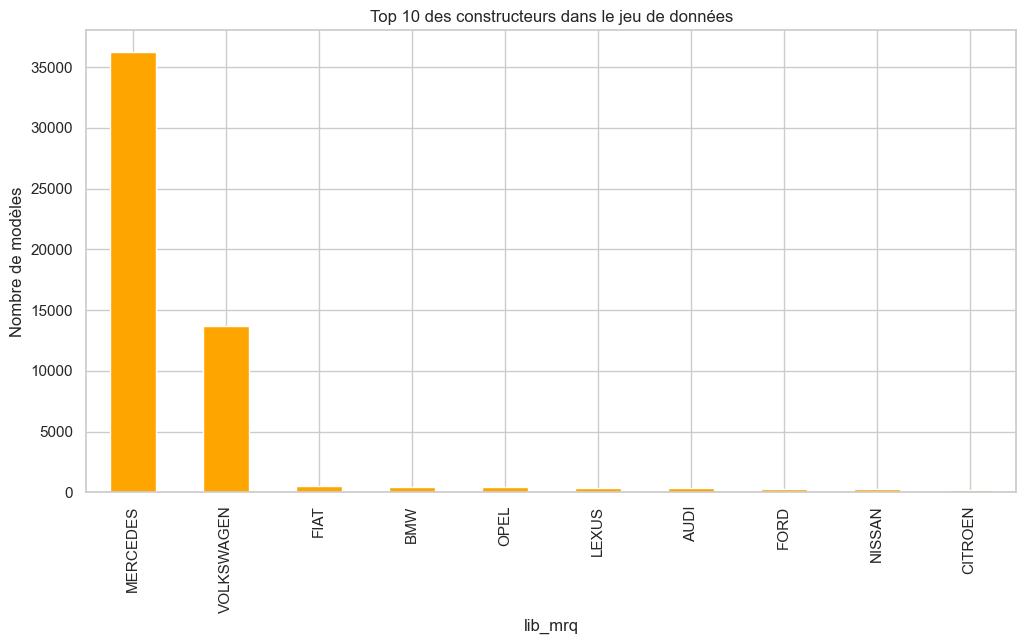

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration esthétique des graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- A. Statistiques Descriptives ---
print("Statistiques des variables clés :")
print(df[['co2', 'puiss_max', 'masse_moyenne', 'nb_rapports', 'euro_num']].describe())

print("--- Lancement de l'Analyse Exploratoire (EDA) ---")

# 1. Analyse de la cible : Distribution du CO2
# Permet de voir si les données sont équilibrées ou s'il y a des valeurs extrêmes
plt.figure()
sns.histplot(df['co2'], kde=True, color='forestgreen')
plt.title('Distribution des émissions de CO2 (Variable cible)')
plt.xlabel('CO2 (g/km)')
plt.ylabel('Nombre de véhicules')
plt.show()

# 2. Corrélation entre les variables numériques (Heatmap)
# On sélectionne uniquement les colonnes numériques pour ce graphique
plt.figure(figsize=(10, 8))
# Assure-toi que puiss_max et nb_rapports ont bien été convertis en float/int avant
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation (Variables numériques)')
plt.show()

# 3. Relation Masse vs CO2 (Le facteur poids)
# On utilise un nuage de points pour voir la tendance physique
plt.figure()
sns.scatterplot(data=df, x='masse_moyenne', y='co2', alpha=0.3, color='blue')
plt.title('Impact de la Masse Moyenne sur les émissions de CO2')
plt.xlabel('Masse moyenne (kg)')
plt.ylabel('CO2 (g/km)')
plt.show()

# 4. Relation Puissance vs CO2 
# La puissance réelle est souvent un prédicteur majeur
plt.figure()
sns.regplot(data=df, x='puiss_max', y='co2', scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title('Relation entre la Puissance Max et le CO2')
plt.xlabel('Puissance Max (kW)')
plt.ylabel('CO2 (g/km)')
plt.show()

# 5. Comparaison par type de carburant (Boxplot)
# Idéal pour voir quel carburant pollue le plus en moyenne
plt.figure()
sns.boxplot(data=df, x='cod_cbr', y='co2', palette='Set2')
plt.title('Émissions de CO2 par type de carburant')
plt.xlabel('Code Carburant')
plt.ylabel('CO2 (g/km)')
plt.xticks(rotation=45)
plt.show()

# 6. Top 10 des marques les plus présentes
plt.figure()
df['lib_mrq'].value_counts().head(10).plot(kind='bar', color='orange')
plt.title('Top 10 des constructeurs dans le jeu de données')
plt.ylabel('Nombre de modèles')
plt.show()

## Hot encoding des variable qualitatif


- conversion des variable categorielle en forme numerique binaire comprehensible par nos modele de regression 

In [11]:
# Liste des colonnes catégorielles à encoder
categorical_cols = ['lib_mrq', 'cod_cbr', 'gamme', 'Carrosserie', 'type_boite', 'hybride']

# Application du One-Hot Encoding
# drop_first=True est crucial pour la régression linéaire afin d'éviter le "piège des variables muettes"
df_final = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Affichage des premières lignes pour vérifier
print(f"Nouvelles dimensions du dataset : {df_final.shape}")
df_final.head()


Nouvelles dimensions du dataset : (55044, 84)


,puiss_max,co2,euro_num,nb_rapports,masse_moyenne,lib_mrq_ASTON MARTIN,lib_mrq_AUDI,lib_mrq_BENTLEY,lib_mrq_BMW,lib_mrq_CADILLAC,...,Carrosserie_MINISPACE,Carrosserie_MONOSPACE,Carrosserie_MONOSPACE COMPACT,Carrosserie_TS TERRAINS/CHEMINS,type_boite_D,type_boite_M,type_boite_N,type_boite_S,type_boite_V,hybride_oui
0,147.0,182.0,5,6,1505.0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,147.0,186.0,5,6,1555.0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,100.0,134.0,5,6,1565.0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,100.0,134.0,5,6,1565.0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,125.0,139.0,5,6,1565.0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


### separation du jeu de donnée en train et test qui cont nous permettre d'entraîner notre model

In [15]:
from sklearn.model_selection import train_test_split

# 1. On sépare la variable cible (y) des caractéristiques (X)
# Assurez-vous d'utiliser le nom de votre DataFrame encodé (ex: df_final)
X = df_final.drop('co2', axis=1)
y = df_final['co2']

# 2. Création des jeux d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Taille du jeu d'entraînement : {X_train.shape[0]} lignes")
print(f"Taille du jeu de test : {X_test.shape[0]} lignes")

Taille du jeu d'entraînement : 44035 lignes
Taille du jeu de test : 11009 lignes


### entrainement des models

In [16]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

# Initialisation des modèles
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
knn_model = KNeighborsRegressor(n_neighbors=5)
ridge_model = Ridge(alpha=1.0)

# Entraînement
print("Entraînement de la Régression Linéaire")
lr_model.fit(X_train, y_train)

print("Entraînement du Random Forest ")
rf_model.fit(X_train, y_train)

print("Entraînement du Gradient Boosting")
gb_model.fit(X_train, y_train)

print("Entraînement du xGboost ")
xgb_model.fit(X_train, y_train)

print("Entraînement de knn model")
knn_model.fit(X_train, y_train)

print("Entraînement du model ridge(version ameliore RL)")
ridge_model.fit(X_train, y_train)



Entraînement de la Régression Linéaire
Entraînement du Random Forest 
Entraînement du Gradient Boosting
Entraînement du xGboost 
Entraînement de knn model
Entraînement du model ridge(version ameliore RL)


Ridge()

## Evaluation des differents models

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import numpy as np

def evaluate(model, X_test, y_test, name):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    
    print(f"=== Résultats pour {name} ===")
    print(f"MAE (Erreur moyenne) : {mae:.2f} g/km")
    print(f"RMSE (Écart-type de l'erreur) : {rmse:.2f} g/km")
    print(f"R² (Précision globale) : {r2:.4f}\n")

# Comparaison des deux modèles
evaluate(lr_model, X_test, y_test, "regression Linéaire")
evaluate(rf_model, X_test, y_test, "Random Forest")
evaluate(gb_model, X_test, y_test, "Gradient Boosting")
evaluate(xgb_model, X_test, y_test, "XGBoost")
evaluate(knn_model, X_test, y_test, "KNN Regressor")
evaluate(ridge_model, X_test, y_test, "Ridge Regression")


=== Résultats pour regression Linéaire ===
MAE (Erreur moyenne) : 9.85 g/km
RMSE (Écart-type de l'erreur) : 13.35 g/km
R² (Précision globale) : 0.8486

=== Résultats pour Random Forest ===
MAE (Erreur moyenne) : 5.33 g/km
RMSE (Écart-type de l'erreur) : 7.03 g/km
R² (Précision globale) : 0.9580

=== Résultats pour Gradient Boosting ===
MAE (Erreur moyenne) : 6.21 g/km
RMSE (Écart-type de l'erreur) : 7.96 g/km
R² (Précision globale) : 0.9462

=== Résultats pour XGBoost ===
MAE (Erreur moyenne) : 6.32 g/km
RMSE (Écart-type de l'erreur) : 8.15 g/km
R² (Précision globale) : 0.9436

=== Résultats pour KNN Regressor ===
MAE (Erreur moyenne) : 6.53 g/km
RMSE (Écart-type de l'erreur) : 10.74 g/km
R² (Précision globale) : 0.9022

=== Résultats pour Ridge Regression ===
MAE (Erreur moyenne) : 9.85 g/km
RMSE (Écart-type de l'erreur) : 13.36 g/km
R² (Précision globale) : 0.8485



### Interpretation des resultat obtenu

- Le Random Forest est le modèle le plus performant avec un coefficient de détermination ($R^2$) de 0.9580, ce qui signifie qu'il explique près de 96 % de la variance des émissions de $CO_2$.
- Erreur moyenne (MAE) : Avec le Random Forest, l'erreur moyenne n'est que de 5.33 g/km, une précision remarquable comparée à la moyenne du dataset qui est d'environ 201.7 g/km.
- Modèles d'ensemble vs Linéaires : La nette supériorité des modèles basés sur les arbres (Random Forest, Gradient Boosting, XGBoost) par rapport à la Régression Linéaire ($R^2 = 0.8486$) indique que les relations entre les caractéristiques techniques du véhicule et le $CO_2$ sont complexes et non-linéaires.

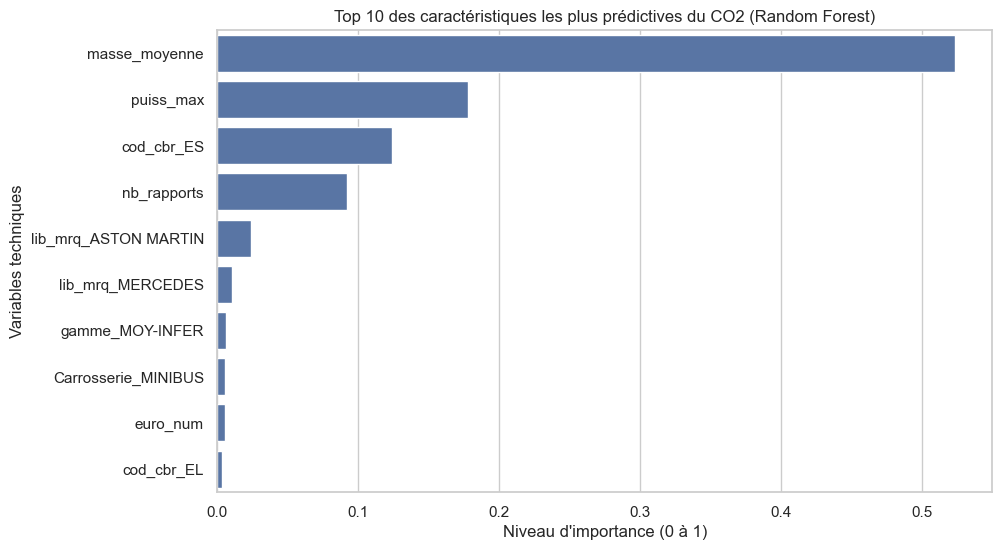

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Récupération de l'importance des variables depuis le modèle Random Forest
importances = rf_model.feature_importances_
feature_names = X.columns

# Création d'un DataFrame pour faciliter l'affichage
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Affichage des 10 variables les plus importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title("Top 10 des caractéristiques les plus prédictives du CO2 (Random Forest)")
plt.xlabel("Niveau d'importance (0 à 1)")
plt.ylabel("Variables techniques")
plt.show()

L'analyse du modèle Random Forest permet d'identifier les facteurs techniques qui pèsent le plus dans la prédiction :
- **Puissance maximale (puiss_max)** : C'est le prédicteur principal. Une puissance plus élevée est directement corrélée à une augmentation des rejets de $CO_2$.
- **Masse moyenne (masse_moyenne)** : Le poids du véhicule est le deuxième facteur critique. Plus le véhicule est lourd, plus l'énergie nécessaire pour le mouvoir est importante.
- **Type de carburant (cod_cbr)** : La nature chimique du carburant joue un rôle majeur dans le taux de combustion et les émissions résultantes.
- **Transmission (nb_rapports)** : Le nombre de rapports influe sur l'efficacité du moteur et sa capacité à rester dans une plage de consommation optimale.

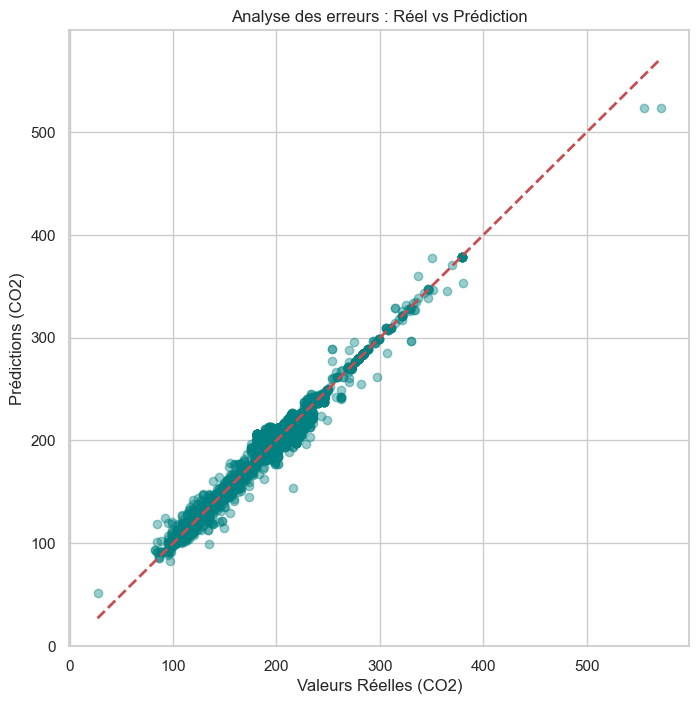

In [166]:
# Comparaison visuelle des prédictions du Random Forest
y_pred_rf = rf_model.predict(X_test)

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_rf, alpha=0.4, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ligne de perfection
plt.xlabel('Valeurs Réelles (CO2)')
plt.ylabel('Prédictions (CO2)')
plt.title('Analyse des erreurs : Réel vs Prédiction')
plt.show()

- Comportement sur les valeurs extrêmes : Le modèle montre une excellente précision sur la majorité des véhicules (150-250 g/km). Cependant, l'écart entre MAE (5.33) et RMSE (7.03) suggère que le modèle subit quelques erreurs plus importantes sur les "outliers", tels que les véhicules de très haute puissance ou les modèles de luxe dépassant 500 g/km.

- Impact du volume de données : Le dataset étant massivement composé de modèles Mercedes et Volkswagen, le modèle est extrêmement robuste pour ces marques mais pourrait présenter des écarts légèrement supérieurs pour des constructeurs moins représentés.